# SpQR application on a Higgs dataset


In this notebook we train the SpQR model on the dataset HIGGS.csv from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS).

This notebook is divided essentially in five parts:

    1. Downloading and preparing (slicing) the dataset
    2. Plotting features (to get an initial idea)
    3. Initializing the model
    4. Fitting and evaluating performances
    5. Plotting results


## Package needed

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !git clone https://github.com/MarcoRiggirello/diglm

In [2]:
import sys
import os

sys.path.append('diglm/src')
sys.path.append('../../../src')

import logging

# sinlencing tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import imageio
from PIL import Image

import tensorflow as tf
from tensorflow_probability import distributions as tfd
from tensorflow_probability import glm as tfglm
from tensorflow_probability import bijectors as tfb
from tensorflow.keras import metrics

from spqr import NeuralSplineFlow as NSF
from diglm import Diglm

from download import download_file

## Downloading data

To download the dataset we use the function download_file in the `download.py` module: it will check if the dataset already exists in the current directory or download it from the internet.

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
file_path = os.path.join('../model_test/download/HIGGS.csv.gz')
download_file(url, file_path)

## Plotting features of the dataset

We use seaborn to display scatterplot matrices of the correlation between features in the dataset.

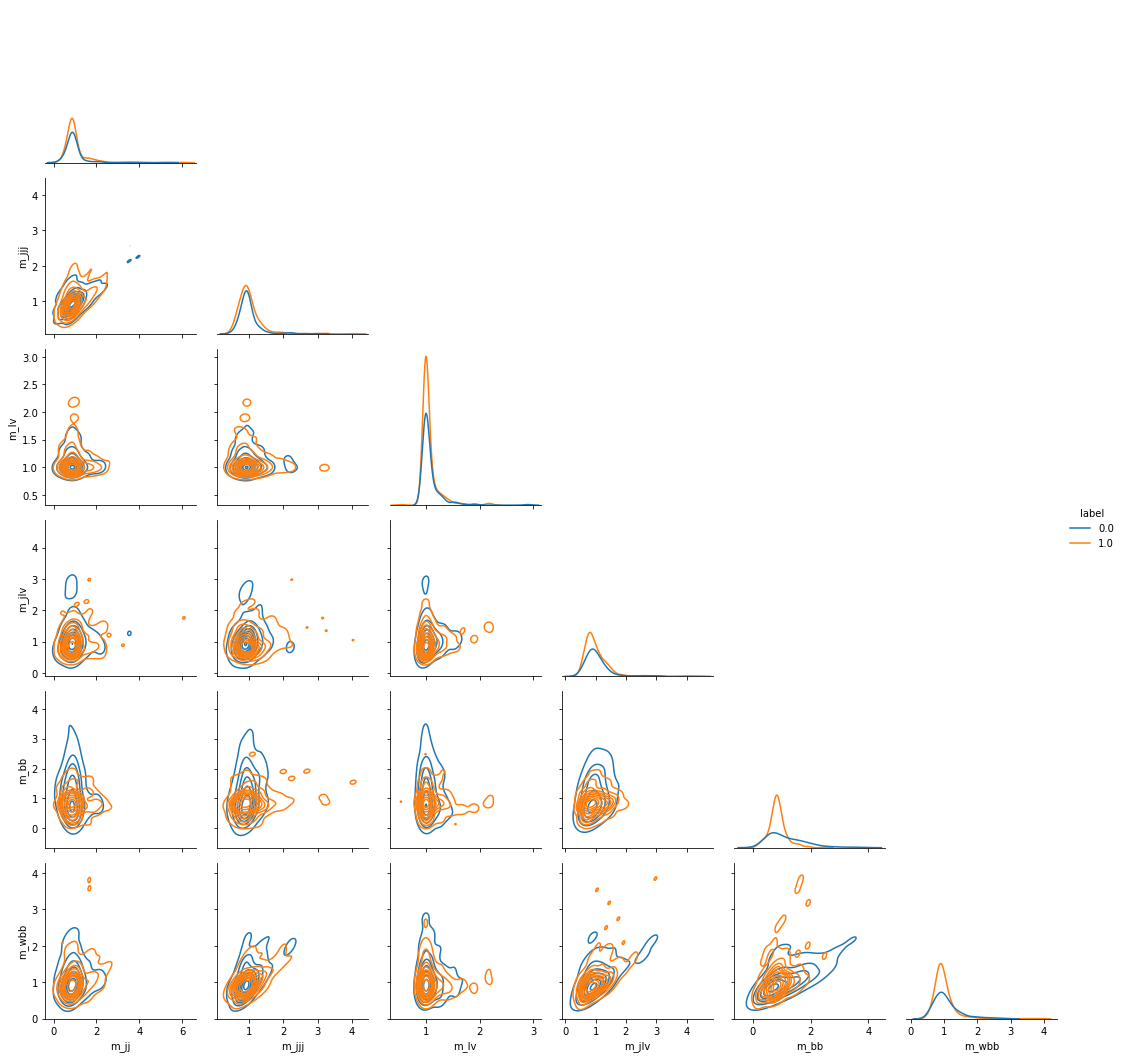

In [4]:
column_labels = ['label','lepton pT', 'lepton eta', 'lepton phi',
                 'missing energy magnitude', 'missing energy phi',
                 'jet 1 pt', 'jet 1 eta', 'jet 1 phi',
                 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta',
                 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt',
                 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag',
                 'jet 4 pt', 'jet 4 eta', 'jet 4 phi',
                 'jet 4 b-tag', 'm_jj', 'm_jjj','m_lv',
                 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
data = pd.read_csv(file_path,
                   header=0,
                   names=column_labels,
                   nrows=8192*32)

# Creating a gif of  correlation scatter plots... but another time                                                                      
"""
tuple_var = [(1, 7), (8, 14), (15, 21), (22, 28)]
grid_list = [sns.PairGrid(data.head(500),
                          hue='label',
                          vars=column_labels[init:end],
                          corner=True)
             for init, end in tuple_var]

fig_list = []
for i, grid in enumerate(grid_list):
    grid.map_diag(sns.kdeplot)
    grid.map_offdiag(sns.kdeplot)
    grid.add_legend()
    fig_name = f'sns_plot{i}.png'
    grid.savefig(fig_name)
    fig_list.append(imageio.imread(fig_name))

imageio.mimsave('sns.gif',
                fig_list,
                duration = 5)
im = Image.open('sns.gif')
im.show()
"""
grid = sns.PairGrid(data.head(500),
                    hue='label',
                    vars=column_labels[22:28],
                    corner=True)
grid.map_diag(sns.kdeplot)
grid.map_offdiag(sns.kdeplot)
grid.add_legend()

## Slicing data: train, validation, test

We slice the dataframe to obtain train and test samples.
Data appear to have mixed labels already, so that a simple slicing is sufficient to obtain good sampling.

There are 11 milions entries: the last 500k are used as tests, as in the [original paper](https://www.nature.com/articles/ncomms5308.pdf).

In [5]:
BATCH_SIZE = 2048
TRAIN_SIZE = BATCH_SIZE * 64
VAL_SIZE = BATCH_SIZE 
TEST_SIZE = BATCH_SIZE * 16

ft_train = tf.convert_to_tensor( data[column_labels[22:]].head(TRAIN_SIZE).astype('float32') )
ft_val = tf.convert_to_tensor( data[column_labels[22:]].head(VAL_SIZE).astype('float32') )
ft_test = tf.convert_to_tensor(data[column_labels[22:]].tail(TEST_SIZE).astype('float32') )

l_train = tf.convert_to_tensor( data[column_labels[0]].head(TRAIN_SIZE).astype('int32') )
l_val = tf.convert_to_tensor( data[column_labels[0]].head(VAL_SIZE).astype('int32') )
l_test = tf.convert_to_tensor( data[column_labels[0]].tail(TEST_SIZE).astype('int32') )

Next, we convert our data in a suitable form for subsequent operations.

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices({'features': ft_train, 'labels': l_train}).batch(BATCH_SIZE)

val_dict = {'features': ft_val, 'labels': l_val}

test_ds = tf.data.Dataset.from_tensor_slices({'features': ft_test, 'labels': l_test}).batch(BATCH_SIZE)

## Building the DIGLM model

In the following block, we build our Deeply Invertible Generalized Linear Model (DIGLM) algorithm.
We will then be able to train the model on labelled data.

The steps to create and train the model are:

1. Create the desired transformed outputs from a simple distribution with the same dimensionality as the input data;
2. Initialize the NeuralSplineFlow bijector;
3. Initialize the DIGLM model;
4. Create the training step functions.


In [7]:
neural_spline_flow = NSF(masks=[-5,-3,-1,1,3,5], spline_params=dict(nbins=32, hidden_layers=[64,64]))
gen_linear_model = tfglm.Bernoulli()
NUM_FEATURES = 7

d = Diglm(neural_spline_flow, gen_linear_model, NUM_FEATURES)

We define training function to loop over train data.

In [8]:
@tf.function
def train_step(optimizer, target_sample, weight):
    """
    Train step function for the diglm model. Implements the basic steps for computing
    and updating the trainable variables of the model. It also
    calculates the loss on training and validation samples.

    :param optimizer: Optimizer fro gradient minimization (or maximization).
    :type optimizer: A keras.optimizers object
    :param target_sample: dictonary of labels and features of data to train the model
    :type target_sample: dict

    """

    with tf.GradientTape() as tape:
        # calculating loss and its gradient of training data
        loss = -tf.reduce_mean(d.weighted_log_prob(target_sample, scaling_const=weight))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

## Training

We go on training the algorithm on train dataset. We also check for the loss on validation samples.


In [9]:
accuracy = metrics.BinaryAccuracy()

def update_accuracy():
    """
    util function to update the binary accuracy metric
    to evaluate the algorithm performances.
    """
    accuracy.reset_state()
    y_true = val_dict['labels']
    y_pred, y_var, grad = d(val_dict['features'])
    accuracy.update_state(y_true, y_pred.numpy().T)
    return accuracy.result().numpy()

LR = 5e-3
NUM_EPOCHS = 10

weight = .5

history = {'accuracy': [], 'train_loss': [], 'val_loss': []}

trnl = 0.
vall = 0.
accu = 0.

learning_rate = tf.Variable(LR, trainable=False)
optimizer = tf.keras.optimizers.Adam(learning_rate)

print(f'\t\t| TRAIN_LOSS\t| VAL_LOSS\t| ACCURACY\t|')
for epoch in range(NUM_EPOCHS):
    for i, batch in enumerate(train_ds):
        trnl = train_step(optimizer, batch, weight)
        history['train_loss'].append(trnl)
        vall = -tf.reduce_mean(d.weighted_log_prob(val_dict, scaling_const=weight))
        history['val_loss'].append(vall)
        accu = update_accuracy()
        history['accuracy'].append(accu)
        #print(f'Batch {i+1} \t| {trnl:.3f}    \t| {vall:.3f}    \t| {accu:.3f}   \t|', end='\r')
    
    print(f'EPOCH: {epoch+1} \t| {trnl:.3f}    \t| {vall:.3f}    \t| {accu:.3f}   \t|')

		| TRAIN_LOSS	| VAL_LOSS	| ACCURACY	|
EPOCH: 1 	| 1435.615    	| 1431.152    	| 0.609   	|
EPOCH: 2 	| 1431.712    	| 1428.500    	| 0.545   	|
EPOCH: 3 	| 1430.278    	| 1426.300    	| 0.542   	|
EPOCH: 4 	| 1428.898    	| 1425.198    	| 0.552   	|
EPOCH: 5 	| 1427.459    	| 1423.913    	| 0.553   	|
EPOCH: 6 	| 1425.805    	| 1423.665    	| 0.563   	|
EPOCH: 7 	| 1424.953    	| 1423.551    	| 0.570   	|
EPOCH: 8 	| 1425.096    	| 1422.886    	| 0.583   	|
EPOCH: 9 	| 1424.896    	| 1422.236    	| 0.573   	|
EPOCH: 10 	| 1423.904    	| 1423.681    	| 0.560   	|


## Results

To illustrate the results of the training, we plot the loss and accuracy history.

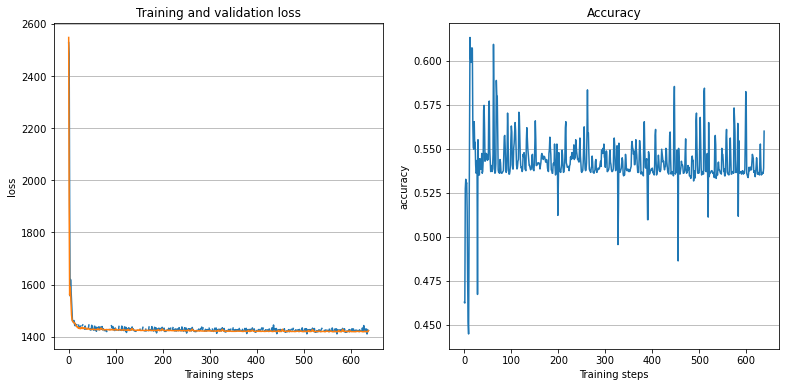

In [10]:
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.title('Training and validation loss')
plt.plot(history['train_loss'][1:], label='train loss')
plt.plot(history['val_loss'][1:], label='val loss')
plt.xlabel('Training steps')
plt.ylabel('loss')
plt.grid(axis='y')

# accuracy plot
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history['accuracy'][1:])
plt.xlabel('Training steps')
plt.ylabel('accuracy')
plt.grid(axis='y')